In [1]:
import os, random, matplotlib, pickle, yaml
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob

SMALL_SIZE, MEDIUM_SIZE = 9, 12

In [2]:
result_path = "/Users/donghur/Desktop/Research/Murthy/BM_GPU/results/round2_legs_antennae_resnet101"

with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])
    
config_path = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [50]:
tot_embed = []
for file in tqdm(INFO_values):
    tot_embed.append( np.load(f"/Users/donghur/Desktop/Research/Murthy/BM_GPU/{file['directory']}/embeddings.npy") )
tot_embed = np.concatenate(tot_embed)

In [4]:
file_key = "01BWmidfr_antmovie200929185530"
data_path = f"{result_path}/{file_key}"

macro_bp = np.load(f"{data_path}/bodypoints.npy")
macro_bp_scaled = np.load(f"{data_path}/scaled_bodypoints.npy")
macro_bp_rotated = np.load(f"{data_path}/rotated_bodypoints.npy")
macro_body_orientation = np.load(f"{data_path}/body_orientation_angles.npy")
macro_angles = np.load(f"{data_path}/angles.npy")
macro_power = np.load(f"{data_path}/power.npy")
macro_embed = np.load(f"{data_path}/embeddings.npy")
macro_cluster = np.load(f"{data_path}/clusters.npy")
macro_loc = np.load(f"{data_path}/global_location.npy")
# macro_loc /= config["camera_scale"]

print(f"macro_angles: {macro_angles.shape}")   
print(f"macro_power: {macro_power.shape}")   
print(f"macro_embed: {macro_embed.shape}")   
print(f"macro_loc: {macro_loc.shape}")   

macro_angles: (16719, 8, 2)
macro_power: (8, 21, 16719)
macro_embed: (16719, 3)
macro_loc: (16719, 2)


In [18]:
food_loc_center = (45, 20.5)
food_loc_radius = 3.4
arena_corner = [1.25, 1.25]
arena_width = [65.76666666666667, 39.166666666666664]
xlim = (-2.040506516160523, 70.30717318282719)
ylim = (-0.7121574771919621, 42.37882414385862)

def arena_fd_figure():
    fig, ax = plt.subplots(figsize=(12,7))
    
    # Food Location
    food_circle = matplotlib.patches.Circle(food_loc_center,
                             food_loc_radius,
                             linewidth=2,edgecolor='g',facecolor='none')
    arena_rect = matplotlib.patches.Rectangle(arena_corner,
                             arena_width[0], arena_width[1],
                             linewidth=2,edgecolor='blue',facecolor='none', alpha=0.3)
    ax.add_patch(food_circle)
    ax.add_patch(arena_rect)
    
    ax.set(xlabel='Length (cm)', ylabel='Width (cm)', title=f"Global Location",
      xlim=xlim, ylim=ylim)
    
    return fig, ax

def arena_fr_figure():
    fig, ax = plt.subplots(figsize=(12,7))
    
    arena_rect = matplotlib.patches.Rectangle(arena_corner,
                             arena_width[0], arena_width[1],
                             linewidth=2,edgecolor='blue',facecolor='none', alpha=0.3)
    ax.add_patch(arena_rect)
    
    ax.set(xlabel='Length (cm)', ylabel='Width (cm)', title=f"Global Location",
      xlim=xlim, ylim=ylim)
    
    return fig, ax

(<Figure size 864x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8089ec5d68>)

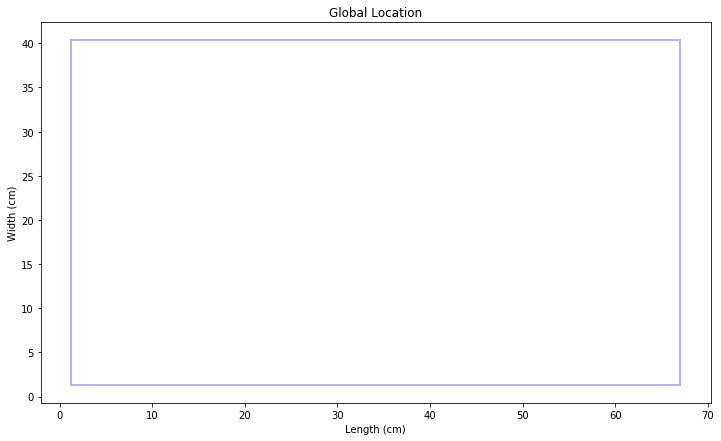

In [90]:
arena_fr_figure()

<hr>
<hr>

In [8]:
macro_loc.shape

(16719, 2)

In [16]:
from scipy import signal

filt_loc = np.zeros(macro_loc.shape)
b, a = signal.butter(8, 0.1)
for i in range(2):
    filt_loc[:,i] = signal.filtfilt(b, a, macro_loc[:,i])

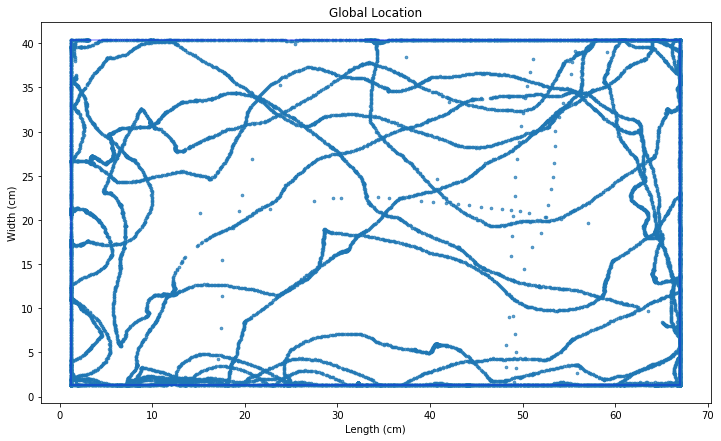

In [30]:
fig, ax = arena_fr_figure()
ax.scatter(macro_loc[:,0], macro_loc[:,1], s=7, alpha=0.7)
plt.show()

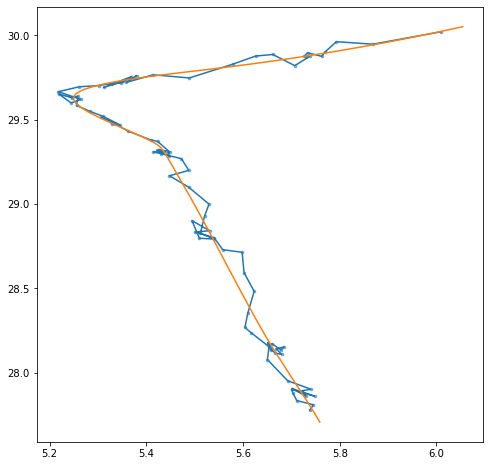

In [28]:
start_fr, stop_fr = 300,400
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(macro_loc[start_fr:stop_fr,0],macro_loc[start_fr:stop_fr,1], alpha=0.5,s=7)
ax.plot(macro_loc[start_fr:stop_fr,0],macro_loc[start_fr:stop_fr,1])
ax.plot(filt_loc[start_fr:stop_fr,0],filt_loc[start_fr:stop_fr,1])
plt.show()

In [38]:
macro_velocity = np.sqrt(np.sum(np.diff(filt_loc, axis=0)**2, axis=1))*config['fps']
# convert above thresh to 0
velocity_thresh = 12
print(len(np.where(macro_velocity > velocity_thresh)[0]))
macro_velocity[macro_velocity > velocity_thresh] = 0

526


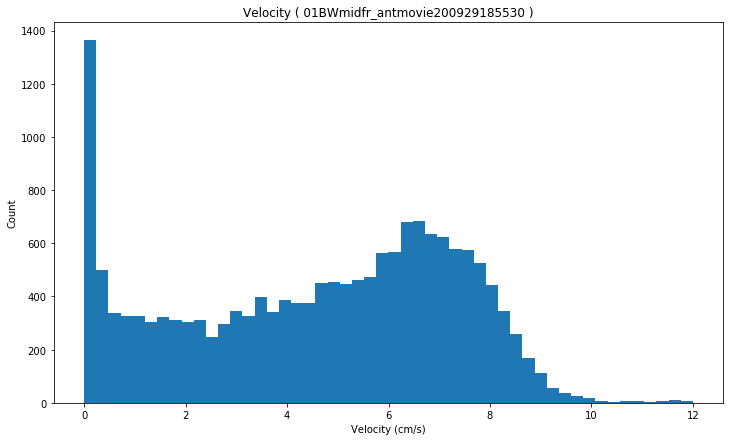

In [39]:
fig, ax = plt.subplots(figsize=(12,7))
ax.hist(macro_velocity, bins=50)
ax.set(xlabel='Velocity (cm/s)', ylabel='Count', title=f"Velocity ( {file_key} )")
plt.show()

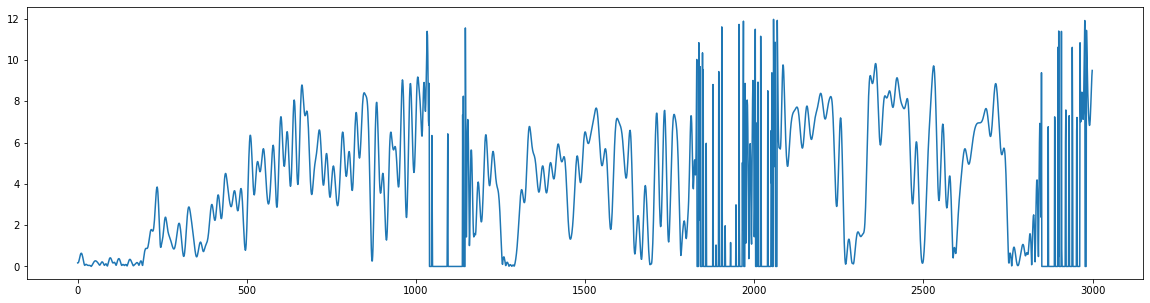

In [62]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(macro_velocity[:3000])
plt.show()

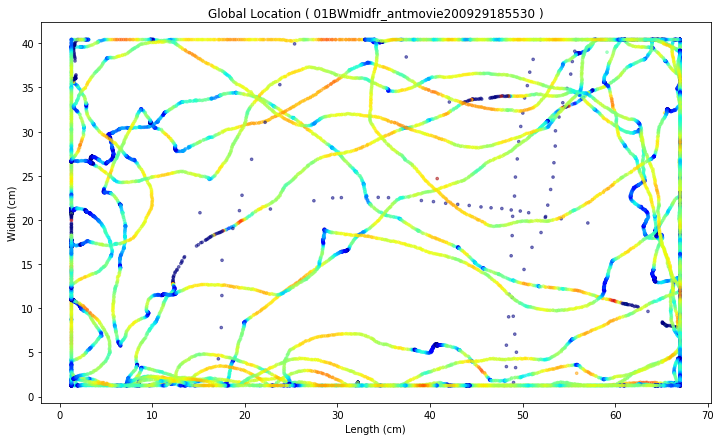

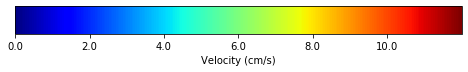

In [42]:
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(macro_loc[:-1,0], macro_loc[:-1,1], s=7, c=macro_velocity, alpha=0.5, cmap="jet")
ax.set(xlabel='Length (cm)', ylabel='Width (cm)', title=f"Global Location ( {file_key} )")
plt.show()


fig, ax = plt.subplots(figsize=(8,1))
fig.subplots_adjust(bottom=0.5)
norm1 = matplotlib.colors.Normalize(vmin=np.min(macro_velocity), vmax=np.max(macro_velocity))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap("jet"), norm=norm1, orientation='horizontal')
cb1.set_label('Velocity (cm/s)')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()

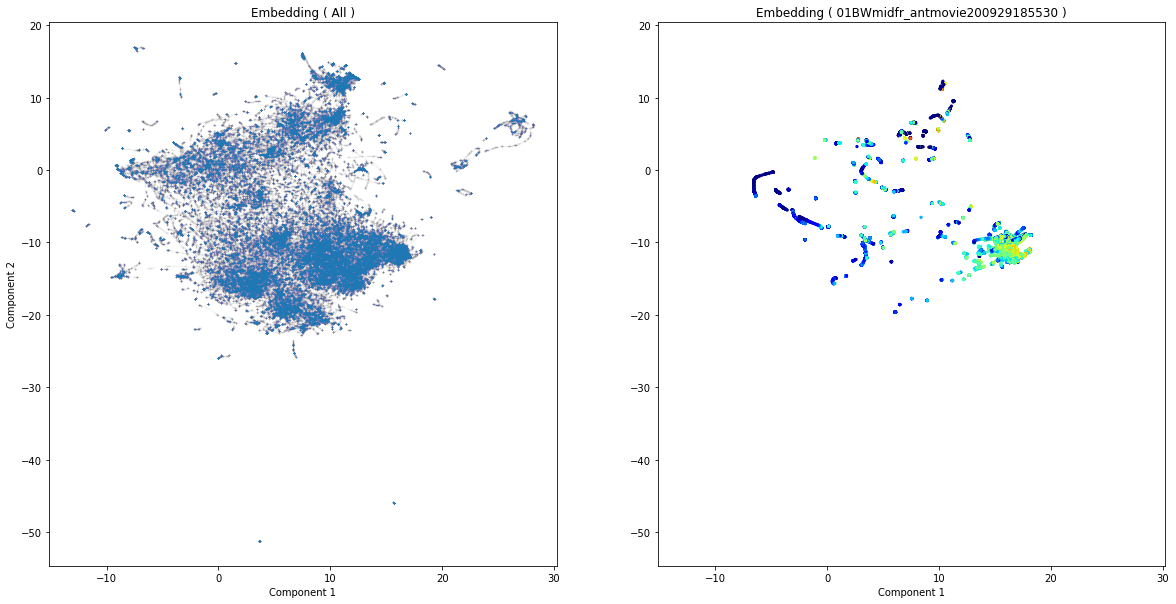

In [64]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].scatter(tot_embed[:,0], tot_embed[:,1], s=3, alpha=0.005)
ax[0].set(title=f"Embedding ( All )", xlabel="Component 1", ylabel="Component 2")
ax[1].scatter(macro_embed[:-1,0], macro_embed[:-1,1], c=macro_velocity, cmap="jet", s=5, alpha=1)
ax[1].set(xlim=ax[0].get_xlim(), ylim=ax[0].get_ylim(), title=f"Embedding ( {file_key} )", xlabel="Component 1")
plt.show()

In [66]:
dash = '-' * 65

print(dash)
print("{:^10s} {:^10s} {:^20s} {:^20s}".format("Cluster", "# Frames", "Mean Velocity", "Std Velocity"))
print(dash)

for clust_i in np.unique(macro_cluster[:-1,0]):
    clust_velocity = macro_velocity[macro_cluster[:-1,0]==clust_i]
    
    mean_velocity = round(np.mean(clust_velocity), 3)
    std_velocity = round(np.std(clust_velocity), 3)
    print("{:^10d} {:<10d} {:^20f} {:^20f}".format(int(clust_i), len(clust_velocity), mean_velocity, std_velocity))

-----------------------------------------------------------------
 Cluster    # Frames     Mean Velocity         Std Velocity    
-----------------------------------------------------------------
    -1     7940             3.456000             2.591000      
    2      17               0.000000             0.000000      
    3      2                6.780000             1.162000      
    5      143              4.059000             2.376000      
    7      44               0.048000             0.045000      
    8      27               2.463000             1.261000      
    9      1                3.550000             0.000000      
    11     109              2.767000             3.391000      
    12     27               0.152000             0.150000      
    13     119              2.915000             2.277000      
    14     425              2.714000             3.625000      
    15     163              4.392000             2.772000      
    17     76               2.291000

# Change in Orientation Angle vs Velocity

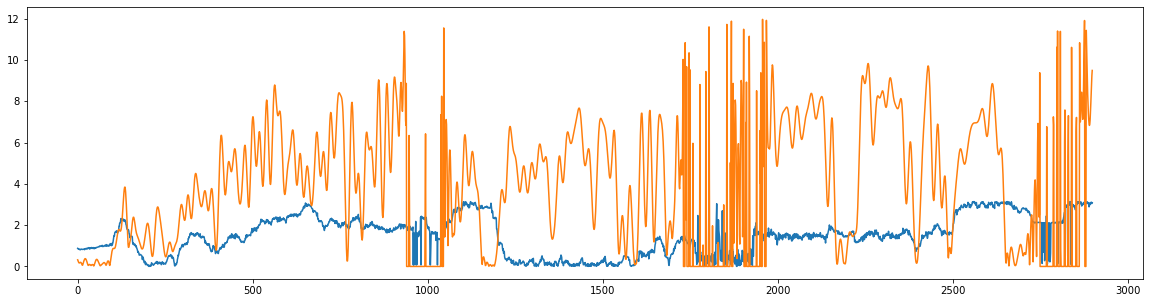

In [89]:
start_fr, stop_fr = 100,3000

abs_bp_orient = np.abs(macro_body_orientation)
change_bp_orient = np.diff(abs_bp_orient)
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(abs_bp_orient[start_fr:stop_fr])
plt.plot(macro_velocity[start_fr:stop_fr])
plt.show()

In [76]:
macro_velocity.shape

(16718,)

In [84]:
change_bp_orient.shape

(16718,)

# Frequency of Stop

**Notes:**
* How to treat jumping points

In [58]:
test_loc = macro_loc[:2000]
test_velocity = macro_velocity[:2000]

stop_idx = test_velocity < 2

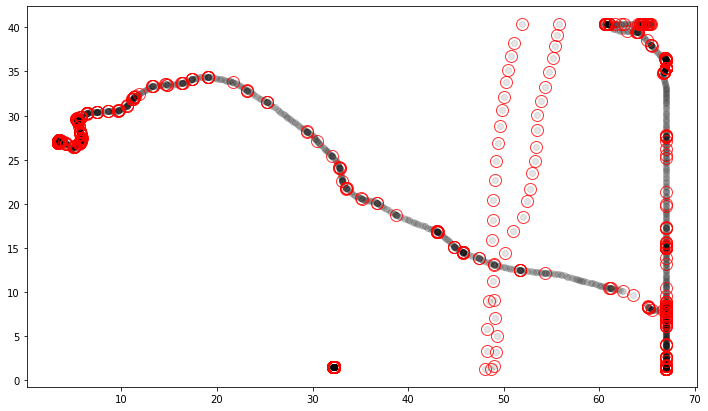

In [59]:
fig, ax = plt.subplots(figsize=(12,7))
plt.scatter(test_loc[:,0], test_loc[:,1], c='k', alpha=0.1)
plt.plot(test_loc[stop_idx,0], test_loc[stop_idx,1], markersize=12, c='r', alpha=0.8, marker='o', linestyle='none', fillstyle='none')
plt.show()

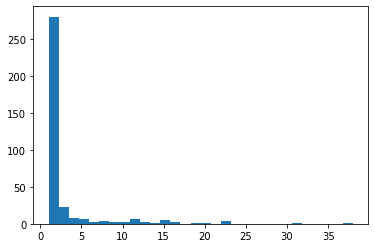

In [55]:
(stop_fr_idx,) = np.where(stop_idx)
plt.hist(np.diff(stop_fr_idx), bins=30)
plt.show()